[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/jrkasprzyk/CVEN5393/blob/main/Colab%20Notebooks/scalar-uncertainties.ipynb)

*This notebook is part of course notes for CVEN 5393: Water Resource Systems and Management, by Prof. Joseph Kasprzyk at CU Boulder.*

# Monte Carlo methods

In a Monte Carlo simulation, repeated random sampling is performed in order to obtain numerical results (often used when conventional deterministic calculations fail)

In general, the procedure is:


1.   Define a domain (and distribution) of possible inputs
2.   Generate inputs randomly from a known probability distribution
3.   Perform a deterministic calculation on the inputs
4.   Aggregate the results

In this notebook, we will focus on **scalar** uncertainties; in other words, the uncertainties that we sample will not be a timeseries but rather a single number.



# Generating random numbers

The default random number that usually is output from a random number generator is a uniformly distributed number between 0 and 1.

If we call the numpy random function, notice that it gives a different random number every time. That sounds great, right?

In [1]:
# first we import
import numpy as np
import plotly.express as px #plotly express for fast interactive plotting
import plotly.graph_objects as go
import pandas as pd

In [2]:
for i in range(5):
  print("My random number is %f" % np.random.rand(1))

My random number is 0.097720
My random number is 0.154409
My random number is 0.920332
My random number is 0.964249
My random number is 0.095678


<ipython-input-2-6ac1ac12c04c>:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print("My random number is %f" % np.random.rand(1))


However, for the purpose of testing code, this is challenging because every time you run the same code, the numbers will change! (try it by hitting play on the cell above).

A random number generator uses a set of calculations that are based on an initial number, called the random seed. The random seed of a random number generator is tied to the system's clock, which really makes the behavior feel 'truly random'.

When testing code, though, we would like to be able to have a *consistent* sequence of random numbers that is predictable. Therefore, we specify the random seed. That random seed is relative to a random number generator object that we save in the variable `rng` below.

In [3]:
# create a random number generator instance with a particular random seed
rng = np.random.default_rng(seed=42)

for i in range(5):
  print("My random number is %f" % rng.random(1))

My random number is 0.773956
My random number is 0.438878
My random number is 0.858598
My random number is 0.697368
My random number is 0.094177


<ipython-input-3-82d45ab4592a>:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print("My random number is %f" % rng.random(1))


If you hit play on that cell several times, you'll notice that the numbers don't change. That's because every time you run that piece of code, you're re-setting the random number generator with `seed=42` every time.

Pay attention to where the random number generator is re-set. Keep in mind that the object is 'running' whenever it is created, so in other words if you generate random numbers somewhere else in the code using `rng`, then that will affect the sequence of random numbers that you see in other code locations.

# Example 1: Find Pi

This example is adapted from: https://blogs.sas.com/content/iml/2016/03/14/monte-carlo-estimates-of-pi.html The method is called an 'area method'. The idea is that we can draw a quarter circle in an x-y coordinate plane with radius, $r=1$:

$$f(x) = \sqrt(1-x^2)$$

Assume that we can generate a point in the square that has an equal chance of being at any position between 0 and 1 (i.e., it has a uniform distribution).

There is some chance that point will fall in the quarter circle, and some chance that it will be outside of the quarter circle. The probability that it is inside the circle is the ratio of the area of the quarter circle to the area of the square.

Let $A_{qc}$ represent the area of the quarter circle and $A_s$ represent the area of the square.

The probability can be estimated numerically:

$$P(\text{point inside circle}) \approx \frac{\text{number of points inside}}{\text{total number of points}}$$

and it relates to area calculations:

$$P(\text{point inside circle}) = \frac{A_{qc}}{A_s} = \frac{\frac{\pi r^2}{4}}{r^2} = \frac{\pi}{4}$$

So if you need to estimate $\pi$, you can combine these equations:

$$\pi \approx 4 \times \frac{\text{number of points inside}}{\text{total number of points}}  $$

The calculation will be wrapped in a function, which will enable us to easily test the calculation with a particular value of `num_samples`, the total number of generated random points.

In [4]:
def area_estimate_pi(my_rng, num_samples):
  # given: a random number generator instance and a number of samples
  # find: pi using area estimate method

  # generate lists, length num_samples, for x and y
  x = my_rng.random(num_samples)
  y = my_rng.random(num_samples)

  # store a 'True' if it is below the curve (i.e., if it is in the quarter circle)
  is_in = y < np.sqrt(1-np.power(x, 2))

  # if true equals 1, and false equals 0, the probability of being in the
  # quarter circle is equal to the average value of this list
  # (i.e., the average is equal to the # of points inside divided by the
  # total number of points)
  return 4.0*np.mean(is_in.astype(int))

In [5]:
# plot results
plot_x = rng.random(100)
plot_y = rng.random(100)
plot_is_in = plot_y < np.sqrt(1-np.power(plot_x, 2))
plot_average = 4.0*np.mean(plot_is_in.astype(int))

plot_df = pd.DataFrame({
    'X': plot_x,
    'Y': plot_y,
    'Is In': plot_is_in
})

x_range = np.linspace(0.0,1.0,100)

fig_area = px.area(x=x_range, y=np.sqrt(1-np.power(x_range, 2)))
fig_scatter = px.scatter(plot_df, x='X', y='Y', color='Is In')
fig_combined = go.Figure(data=fig_area.data + fig_scatter.data)

# square axis
fig_combined.update_xaxes(
    range=[0,1],  # sets the range of xaxis
    constrain="domain",  # meanwhile compresses the xaxis by decreasing its "domain"
)
fig_combined.update_yaxes(
    scaleanchor="x",
    scaleratio=1,
)
fig_combined.update_layout(
    title_text="With 100 samples, pi estimate= %f" % plot_average, # title of plot
    xaxis_title_text='X', # xaxis label
    yaxis_title_text='Y', # yaxis label
)
fig_combined.show()

**Luck of the Draw**

What we realize, though, is that this calculation is dependent on the 'luck of the draw' of the random sample you get.

In the next chunk, we input a value for `num_samples`, and call the function 5 different times to see how the estimate looks.

In [6]:
#start the random number generator
rng = np.random.default_rng(seed=42)

trial_num_samples = 100

for i in range(5):
  this_pi = area_estimate_pi(rng, trial_num_samples)
  print("Using %i points, we estimate pi to be %f, an error of %f" %(trial_num_samples, this_pi, np.pi-this_pi))

Using 100 points, we estimate pi to be 3.360000, an error of -0.218407
Using 100 points, we estimate pi to be 3.200000, an error of -0.058407
Using 100 points, we estimate pi to be 2.960000, an error of 0.181593
Using 100 points, we estimate pi to be 3.400000, an error of -0.258407
Using 100 points, we estimate pi to be 3.000000, an error of 0.141593


In this result, you can see that the calculation is random. If you take five different sets of 100 Monte Carlo samples, there is a decently large variance in what the estimate of Pi ends up being. In the next section we will perform a more formal experiment to explore this.

**Replicating the Monte Carlo simulation**

We now create a new wrapper function that adds an additional variable: `num_replicates`. This variable controls the number of times we repeat the Monte Carlo experiment. This allows us to provide an estimate of the variance of our Monte Carlo estimator.

In [7]:
def replicate_samples(my_rng, num_replicates, num_samples):
  # given: a random number generator instance, a number of replicates for the experiment
  # and a number of samples for each Monte Carlo simulation

  # find: a numpy array that contains num_replicates estimates of the calculation
  replicate_results = np.zeros(num_replicates)
  for j in range(num_replicates):
    replicate_results[j] = area_estimate_pi(my_rng, num_samples)
  return replicate_results

Putting it all together, we will try `num_samples` = 100 to 100,000, and replicate each experiment 5,000 times.

For example, to find the variance of the 100 sample Monte Carlo estimator, we will generate 5,000 separate samples of 100 random numbers, and thus estimate pi 5,000 different times for that value of `num_samples`.

In [8]:
#start the random number generator
rng = np.random.default_rng(seed=42)

pi_100samples = replicate_samples(rng, 5000, 100)
pi_1000samples = replicate_samples(rng, 5000, 1000)
pi_10000samples = replicate_samples(rng, 5000, 10000)
pi_100000samples = replicate_samples(rng, 5000, 100000)

In [9]:
# store the results of all replicates in a dataframe
all_replicates_df = pd.DataFrame({
    '100': pi_100samples,
    '1000': pi_1000samples,
    '10000': pi_10000samples,
    '100000': pi_100000samples,
})

**Results of the replicate experiments show the influence of sample size on the Monte Carlo Estimator**

Below, we look at histograms across the experiments, and plot the standard deviation as a function of experiment size.

In [10]:
fig2 = px.histogram(all_replicates_df, barmode='overlay', color_discrete_sequence=px.colors.qualitative.D3)
fig2.update_layout(
    title_text='Histogram of Pi results using 5000 replicates of Monte Carlo sample sizes', # title of plot
    xaxis_title_text='Pi estimate', # xaxis label
    yaxis_title_text='Count', # yaxis label
    bargap=0.01, # gap between bars of adjacent location coordinates
    bargroupgap=0.01 # gap between bars of the same location coordinates
)
fig2.show()

In [11]:
# store summary results in a dataframe
summary_df = pd.DataFrame({
    'Num Samples': [100, 1000, 10000, 100000],
    'Average': [np.average(pi_100samples),
                np.average(pi_1000samples),
                np.average(pi_10000samples),
                np.average(pi_100000samples)],
    'Std Dev': [np.std(pi_100samples),
                np.std(pi_1000samples),
                np.std(pi_10000samples),
                np.std(pi_100000samples)]
})

In [12]:
summary_df

,Num Samples,Average,Std Dev
0,100,3.137688,0.164483
1,1000,3.141923,0.051544
2,10000,3.141678,0.016377
3,100000,3.141526,0.005210


In [13]:
fig3 = px.line(summary_df, x="Num Samples", y="Std Dev", markers=True)
fig3.show()

# Example 2: Rational Method

The rational method, $Q=CiA$ uses a coefficient, $C$; rainfall intensity, $i$, in inches per hour; and the drainage area, $A$, in acres to find the peak runoff rate, $Q$, with units in cubic feet per second (cfs) (this fudging of units is simply because the native units are "close enough" to cfs!)

In [14]:
def rational_method(C, i, A):
  return C*i*A

A Monte Carlo simulation can show what the distribution of $Q$ is if the input variables to the equation have different distributions. For example:


*   A uniform distribution of $C$
*   A normal distribution of $i$
*   A single known value of $A$

This type of approach is used often in risk assessment, where the equations have risk factors that are multiplicative.

In the below code we generate random values for the input variables in a numpy array, apply them to the `rational_method` function, and show the result.



In [15]:
num_samples = 10000

# C is uniformly distributed
low_C = 0.3
high_C = 0.5
C_samples = (high_C-low_C) * rng.random(num_samples) + low_C

# i is normally distributed
i_mean = 3.0
i_std = 0.5
i_samples = rng.normal(i_mean, i_std, num_samples)

# A is constant
A = 100.0

# Q is the output
Q_output = np.zeros(num_samples)

for i in range(num_samples):
  Q_output[i] = rational_method(C_samples[i], i_samples[i], A)

In [16]:
rational_df = pd.DataFrame({
    'C': C_samples,
    'i': i_samples,
    'A': A,
    'Q': Q_output
})

Now we can look at histograms of the input variables and how they are transformed into the output variable.

<Axes: >

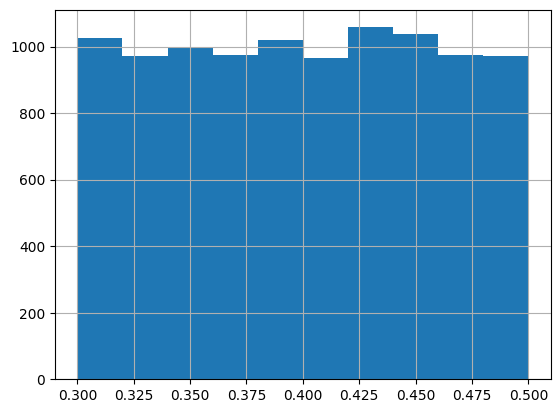

In [17]:
rational_df['C'].hist()

<Axes: >

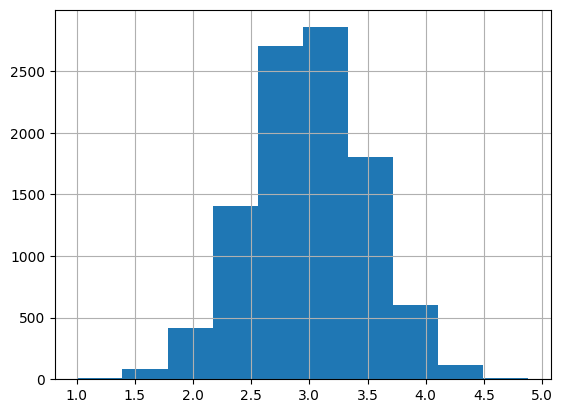

In [18]:
rational_df['i'].hist()

<Axes: >

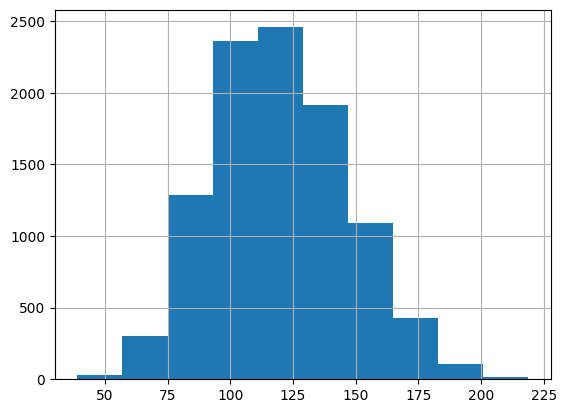

In [19]:
rational_df['Q'].hist()

Often, the result of a Monte Carlo simulation is the expected value of the Monte Carlo samples, so we can say:

In [ ]:
final_Q = np.mean(Q_output)
print("The average Q is %f" % final_Q)

The average Q is 120.046582


# Example 3: Balatro Scoring

A typical hand in the video game Balatro is scored by multiplying chips ($C$) and mult ($M$), so the score ($S$) is expressed as $S_{baseline}=CM$.

In the plasma deck, chips and mult are balanced, which means $S_{plasma}=(\frac{C+M}{2})^2$.

In which combinations of $C$ and $M$ is $S_{plasma} < S_{baseline}$?

Here we will use a full factorial design, with evenly spaced samples for each variable.

In [35]:
def baseline_score(C, M):
  return C*M

def plasma_score(C,M):
  return pow((C+M)/2., 2.)


C_samples = np.linspace(10.,5000.,500)
M_samples = np.linspace(10.,500.,500)

baseline_results = np.empty((500,500))
plasma_results = np.empty((500,500))
is_higher = np.empty((500,500))

for i in range(500):
  for j in range(500):
    baseline_results[i][j] = baseline_score(C_samples[i], M_samples[j])
    plasma_results[i][j] = plasma_score(C_samples[i], M_samples[j])
    if baseline_results[i][j] <= plasma_results[i][j]:
      is_higher[i][j] = 0
    else:
      is_higher[i][j] = 1
      print(f"Baseline is higher when C={C_samples[i]} and M={M_samples[j]}")

In [45]:
plasma_df = pd.DataFrame(plasma_results.flatten())
baseline_df = pd.DataFrame(baseline_results.flatten())

array([[<Axes: title={'center': '0'}>]], dtype=object)

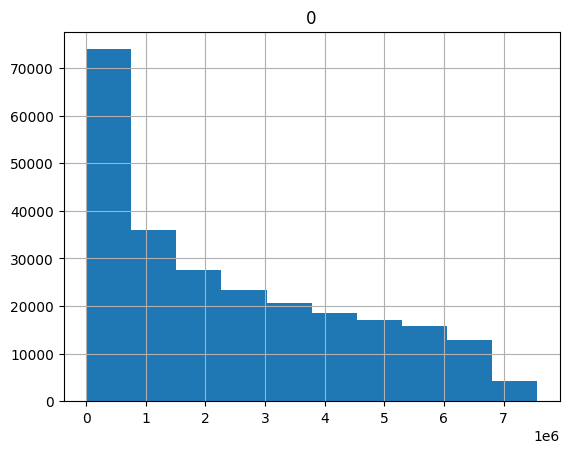

In [44]:
plasma_df.hist()

array([[<Axes: title={'center': '0'}>]], dtype=object)

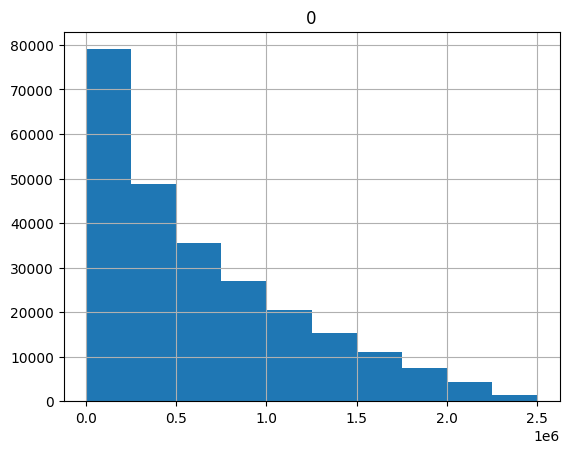

In [46]:
baseline_df.hist()

Results suggest that the plasma results are always at least equal to the baseline results, and when $C=M$, they give the same score.